# w261 Final Project - Clickthrough Rate Prediction


[Your team number (from the spreadsheet)]   
[Your team names]   
Summer 2019, section [Your section numbers>]   

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Course Concepts

# __Section 1__ - Question Formulation

# __Section 2__ - Algorithm Explanation

How do we justify the selection of a particular algorithm for our project?
1. when data is sparse, FM and FFM work better (need to see if the data is sparse)
2. how to justify the choice of FFM over neronets, and trees and other algorithm??

# __Section 3__ - EDA & Challenges

Do we run EDA on the entire dataset or just the sample train data?

In [90]:
from pyspark.sql import types
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan
from pyspark.sql import functions as F
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# run if using local
from pyspark.sql import SparkSession
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

# train_parquet = spark.read.parquet(f"{PWD}/data/train.parquet")
train_parquet = spark.read.parquet(f"{PWD}/data/mediumTrain.parquet")
oldColNames = train_parquet.schema.names

In [ ]:
# run if using wk08 environment
sc = spark.sparkContext
sqlContext = SQLContext(sc)

train_parquet = spark.read.parquet("gs://w261-bucket-hou/final-project/data/train.parquet")
oldColNames = train_parquet.schema.names

In [ ]:
# read training data from bucket and write the parquet format of the file to bucket
# train_data = spark.read.csv("gs://w261-bucket-hou/final-project/data/train.txt", sep="\t")
# train_data.write.format("parquet").save("gs://w261-bucket-hou/final-project/data/train.parquet")

In [ ]:
# PWD = !pwd
# PWD = PWD[0]
# train_data = spark.read.csv(f"{PWD}/data/train.txt", sep="\t")
# train_data.write.format("parquet").save(f"{PWD}/data/train.parquet")
# train_data = spark.read.csv(f"{PWD}/data/mediumTrain.txt", sep="\t")
# train_data.write.format("parquet").save(f"{PWD}/data/mediumTrain.parquet")

In [ ]:
# !gsutil du -sh gs://w261-bucket-hou/final-project/data/train.txt
# !gsutil du -sh gs://w261-bucket-hou/final-project/data/train.parquet

In [ ]:
train_parquet.printSchema()

In [ ]:
#rename files and recast integer types on the first 13 features
train_parquet = train_parquet.withColumn("label", train_parquet["_c0"])
for colNum in range(1,14): 
    colName = "_c" + str(colNum)
    train_parquet = train_parquet.withColumn("int_feature_"+ str(colNum), train_parquet[colName].cast(types.IntegerType()))
for colNum in range(14,40): 
    colName = "_c" + str(colNum)
    train_parquet = train_parquet.withColumn("cate_feature_"+ str(colNum-13), train_parquet[colName])
    
train_parquet = train_parquet.drop(*oldColNames)

In [ ]:
train_parquet.printSchema()

In [ ]:
#record feature names by feature type
intFieldNames = [colName for colName, dType in train_parquet.dtypes if dType == 'int']
cateFieldNames = [colName for colName, dType in train_parquet.dtypes if dType == 'string' and colName != 'label']

In [ ]:
recCount = train_parquet.count() #get record count
fieldCount = len(train_parquet.columns)-1 #get the count of features

In [ ]:
distinctValues = []
nullValues = []
for colName in train_parquet.schema.names:
    distinctValues.append(train_parquet.select(colName).distinct().count())
    nullValues.append(train_parquet.filter((train_parquet[colName] == "") | train_parquet[colName].isNull() | isnan(train_parquet[colName])).count())

In [ ]:
print("Training Dataset Overview:\n")
print("Record Count:", recCount)
print("Field Count:", fieldCount)
print("Null Value Percentage:", str(round(float(sum(nullValues))/(recCount*fieldCount)*100,1)) + "%")

print("="*70, "\n")


print("Column Level Information:\n")
print('%-15s| %-15s| %-15s| %-15s' %('Field Name','Distinct Count', 'Null Count', 'Null Percent'))
print('-'*70)
for colName, distinctVal, nullVal in zip(train_parquet.schema.names, distinctValues, nullValues):
    print('%-15s| %-15s| %-15s| %-15s' %(colName, distinctVal, nullVal, str(round(float(nullVal)/recCount*100,1)) + "%" ))

In [76]:
def get_distinct_summary(df, col, thresholds):
    summary_values = [col]
    summary_values.append(df.select(col).distinct().count())
    
    count_df = df.groupBy(col).count()
    filtered_counts = [count_df.filter(f"count >= {threshold}").count() + 1 for threshold in thresholds]
    summary_values.extend(filtered_counts)
    return summary_values

In [99]:
thresholds = [5, 10, 25, 50, 100, 500, 1000]
distinct_summary = [get_distinct_summary(train_parquet, c, thresholds) for c in cateFieldNames]

In [100]:
test_df = spark.createDataFrame(distinct_summary, ['Feature', 'Distinct'] + [f"count >= {threshold}" for threshold in thresholds] )
test_df.show(40)

+---------------+--------+----------+-----------+-----------+-----------+------------+------------+-------------+
|        Feature|Distinct|count >= 5|count >= 10|count >= 25|count >= 50|count >= 100|count >= 500|count >= 1000|
+---------------+--------+----------+-----------+-----------+-----------+------------+------------+-------------+
| cate_feature_1|     115|        35|         22|         13|          9|           7|           3|            2|
| cate_feature_2|     332|       144|         95|         41|         20|          12|           2|            1|
| cate_feature_3|    3292|        93|         41|         14|          5|           3|           1|            1|
| cate_feature_4|    2421|       122|         55|         17|         10|           6|           1|            1|
| cate_feature_5|      48|        19|         13|         10|          7|           6|           3|            2|
| cate_feature_6|       7|         8|          8|          8|          8|           8|  

In [101]:
distinct_counts = np.asarray(distinct_summary)[:,1:].astype(int)

In [102]:
feat_num = np.sum(distinct_counts, axis = 0)

In [103]:
feat_percent_preserv = np.sum(distinct_counts, axis = 0)/np.sum(distinct_counts, axis = 0)[0]

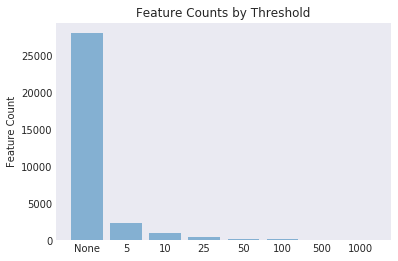

In [104]:
Ts = ['None'] + [f"{threshold}" for threshold in thresholds]
y_pos = np.arange(len(Ts))

plt.bar(y_pos, feat_num, align='center', alpha=0.5)
plt.xticks(y_pos, Ts)
plt.ylabel('Feature Count')
plt.title('Feature Counts by Threshold')

plt.show()

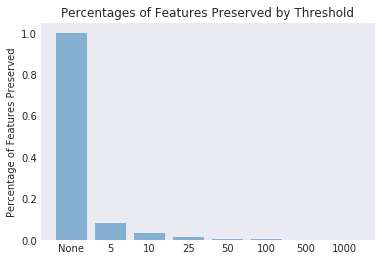

In [105]:
plt.bar(y_pos, feat_percent_preserv, align='center', alpha=0.5)
plt.xticks(y_pos, Ts)
plt.ylabel('Percentage of Features Preserved')
plt.title('Percentages of Features Preserved by Threshold')

plt.show()

In [ ]:
# train_parquet.select('int_feature_1').distinct().count()
# train_parquet.groupBy('cate_feature_3').count().show()
# train_parquet.groupBy('cate_feature_3').count().agg(F.sum('count')).show()

Callenges will be caused by dataset being very sparse:
1. null values in the training data
2. the zeros created by one-hot encoding of the categorical variables (too many distinct values for the categorical variables)

Solutions:
1. feature selections
2. hashing categorical variables

### Goals of the EDA:

Rare values prompts the model to learn from the quirks of the training data. Therefore, the EDA seeks to establish a threshold that will convert a categorical values to a special value if the categorical value has less than a certain count in the training data. This is going to be part of the feature engineering for our model.

Ways to identify the threshold:
1. Look at the number of distinct categorical variables when different thresholds are applied. Note: the number of feature will be the sum of the number of distinct values in all the fields

Another goal is to identify an appropriate way to discretize the numerical variables. 



In [ ]:
# !gsutil cp final_project_hou.ipynb gs://w261-bucket-hou/notebooks/FinalProject/final_project_hou.ipynb

# __Section 4__ - Algorithm Implementation

# __Section 5__ - Course Concepts